# In this notebook I will explore techniques to evaluate and improve machine learning models

In [125]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_blobs

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)

In [2]:
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

In [3]:
def gen_data(m, seed=1, scale=0.7):
    """ Generate a data set based on a x^2 with added noise """

    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal * (np.random.sample((m,))-0.5)
    x_ideal = x_train # for redraw when new data included in X
    return  x_train, y_train, x_ideal, y_ideal

# Split the data

In [4]:
# Generate the data
X, y, x_ideal, y_ideal = gen_data(18, 2, 0.7)
print("X.shape:", X.shape, "y.shape: ", y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print("X_train.shape:", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape:", X_test.shape, "y_test.shape", y_test.shape)

X.shape: (18,) y.shape:  (18,)
X_train.shape: (12,) y_train.shape (12,)
X_test.shape: (6,) y_test.shape (6,)


# Plot Train, Test Sets

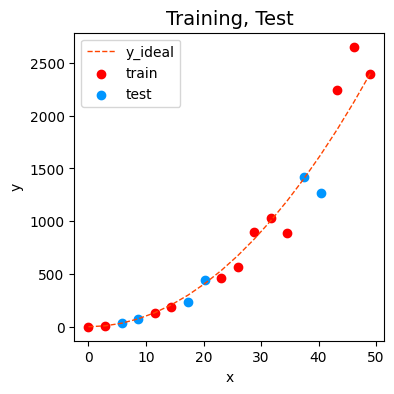

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color='orangered', label="y_ideal", lw=1)
ax.set_title("Training, Test", fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color="r", label="train")
ax.scatter(X_test, y_test, color=dlc["dlblue"], label="test")
ax.legend(loc='upper left')
plt.show()

# Error Calculation for model evaluation, linear regression

$$\textbf{J}_{test} (\textbf{w},b) = \frac{1}{2m_{test}} \sum_{i=0}^{m_{test}-1} (f_{\textbf{w},b}(\textbf{x}_{test}^{(i)}) - y_{test}^{(i)})^2$$

I will implement a function to calculate it.

In [6]:
def my_mse(y, yhat):
    """ 
        Calculate the mean square error on a data set.

        Args:
            y           :  (ndarray(m,) or (m,1))   Target value of each example
            yhat        :  (ndarray(m,) or (m,1)    Predicted value of each example
    
        Returns:
            err(scalar) : mean square error
    """

    m = len(y)
    err = 0.0

    for i in range(m):
        err += (y[i] - yhat[i])**2
        
    err = err / (2*m)

    return (err)

# Compare performance on training and test data

Let's build a high degree polynomial model to minimize the error.

In [7]:
# Create a model in sklearn
class lin_model:
    def __init__(self, degree, regularization=False, lambda_=0):
        if regularization:
            self.linear_model = Ridge(alpha=lambda_)
        else:
            self.linear_model = LinearRegression()
        self.poly = PolynomialFeatures(degree, include_bias=False)
        self.scaler = StandardScaler()

    def fit(self, X_train, y_train):
        """ Just fits the data. Mapping and scaling are not repeated"""
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.linear_model.fit(X_train_mapped_scaled, y_train)

    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return yhat
    
    def mse(self, y, yhat):
        err = mean_squared_error(y, yhat) / 2
        return (err)

In [8]:
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# Predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# Predict on test data, find test error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

In [9]:
print(f"Training error: {err_train:.2f}, Test error: {err_test:.2f}")

Training error: 58.01, Test error: 171215.01


I can observe that the test error is too high. Let's explore why this is in a plot.

In [10]:
def plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax.plot(x_ideal, y_ideal, "--", color='orangered', label="y_ideal", lw=1)
    ax.set_title("Poor Performance on Test Data", fontsize=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")


    ax.scatter(X_train, y_train, color=dlc["dldarkred"], label="Train")
    ax.scatter(X_test, y_test, color=dlc["dldarkblue"], label="Test")
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(x, y_pred, lw=0.5, color=dlc["dlblue"], label=f"Predicted, degree={degree}")
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

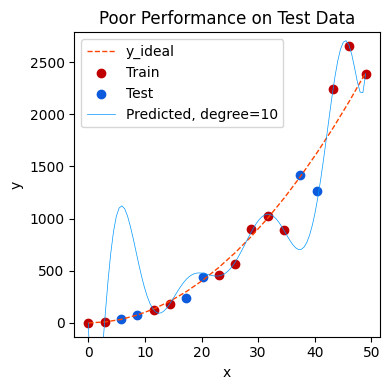

In [11]:
x = np.linspace(0, int(X.max()), 100) # Predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, 10)

As we saw previously, the test error is too high. That means the model will perform bad on new data. According to the split, I used 66.67% for train and 33.33% for test. However, these quantities can vary depending on the size of the data set. Let's explore another alternatives.

In [12]:
# Generate data
X, y, x_ideal, y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape,"Y.shape", y.shape)

# Split the data using sklearn routine
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.50, random_state=1)

del X_, y_

print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) Y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


# Bias and Invariance

Moreover, the degree of the polynomial model was too high. I should change it, but how can I choose a good value? I will try a range of degree values and calculate the performance using the training and cross validation set.

# Train, Cross Validation and Test Visualization

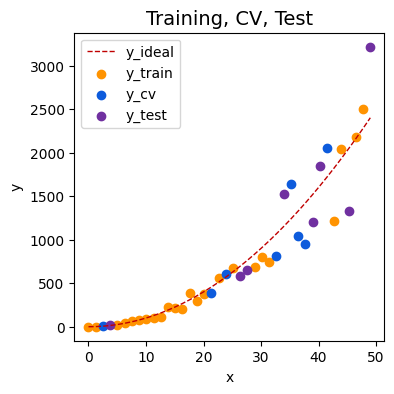

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color=dlc["dldarkred"], label="y_ideal", lw=1)
ax.scatter(X_train, y_train, color=dlc["dlorange"], label="y_train")
ax.scatter(X_cv, y_cv, color=dlc["dldarkblue"], label="y_cv")
ax.scatter(X_test, y_test, color=dlc["dlpurple"], label="y_test")

ax.set_title("Training, CV, Test", fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(loc='upper left')
plt.show()



# Finding the optimal degree

I will use the `scikit-learn` linear regression moderl for speed and simplicity.

In [20]:
max_degree = 9
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, max_degree)) # columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)

optimal_degree = np.argmin(err_cv)+1

In [21]:
print(optimal_degree)

2


# Plot the result

In [84]:
def plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree):
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax[0].scatter(X_train, y_train, color = "black", marker='v',          label="train")
    ax[0].scatter(X_cv, y_cv,       color = "teal", marker='d', label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,max_degree):
        ax[0].plot(x, y_pred[:,i],  lw=0.6, label=f"{i+1}")
    ax[0].legend(loc='upper left')

    ax[1].set_title("error vs degree",fontsize = 12)
    cpts = list(range(1, max_degree+1))
    ax[1].plot(cpts, err_train[0:], marker='o',label="train error", lw=2,  color = dlc["dlblue"])
    ax[1].plot(cpts, err_cv[0:],    marker='o',label="cv error",  lw=2, color = dlc["dlorange"])
    ax[1].set_ylim(*ax[1].get_ylim())
    ax[1].axvline(optimal_degree, lw=1, color = dlc["dlmagenta"])
    ax[1].annotate("optimal degree", xy=(optimal_degree,80000),xycoords='data',
                xytext=(0.3, 0.8), textcoords='axes fraction', fontsize=10,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3", 
                                   color=dlc['dldarkred'], lw=1))
    ax[1].set_xlabel("degree")
    ax[1].set_ylabel("error")
    ax[1].legend()
    fig.suptitle("Find Optimal Degree",fontsize = 12)
    plt.tight_layout()

    plt.show()

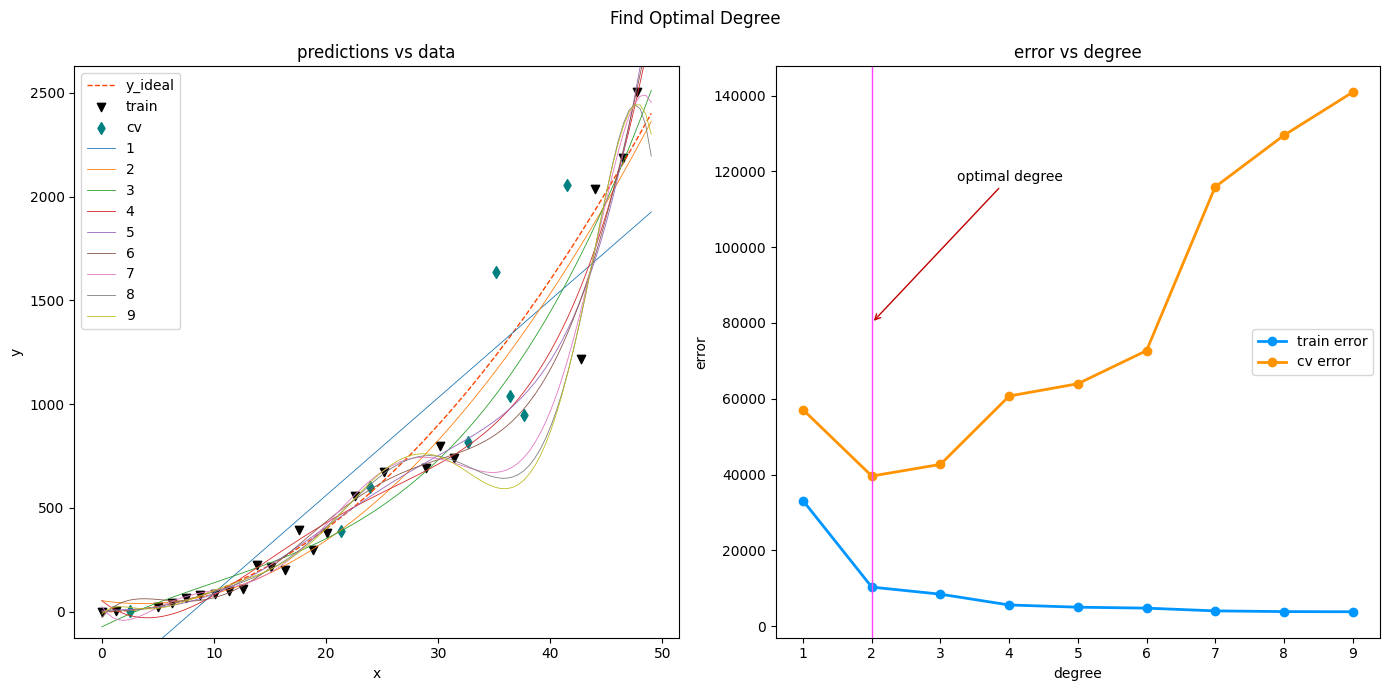

In [85]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree)

I can notice in the left plot that the higher the degree is, the better fits to the train data. However, in the right plot, I realize that the train error starts to decrease while the degree increase. Conversely, the cross validation error starts to decrease for a 2-degree model, but it increases for higher degrees leading to over-fit on the training data.

# Tuning Regularization

In the step, I will to tune the regularization parameter lambda $\lambda$ .

In [87]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)
err_cv = np.zeros(num_steps)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, num_steps))     # columns are lines to plot

for i in range(num_steps):
    lambda_ = lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_= lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)

optimal_reg_idx = np.argmin(err_cv)

In [88]:
print(optimal_reg_idx)

7


In [89]:
def plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
#   ax[0].plot(x, y_pred[:,:],  lw=0.5, label=[f"$\lambda =${i}" for i in lambda_range])
    for i in (0,3,7,9):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
    ax[0].legend()

    ax[1].set_title("error vs regularization",fontsize = 12)
    ax[1].plot(lambda_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xscale('log')
    ax[1].set_ylim(*ax[1].get_ylim())
    opt_x = lambda_range[optimal_reg_idx]
    ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)
    ax[1].annotate("optimal lambda", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
                  arrowprops={'arrowstyle':'simple'})
    ax[1].set_xlabel("regularization (lambda)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning Regularization",fontsize = 12)
    ax[1].text(0.05,0.44,"High\nVariance",fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.44,"High\nBias",    fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

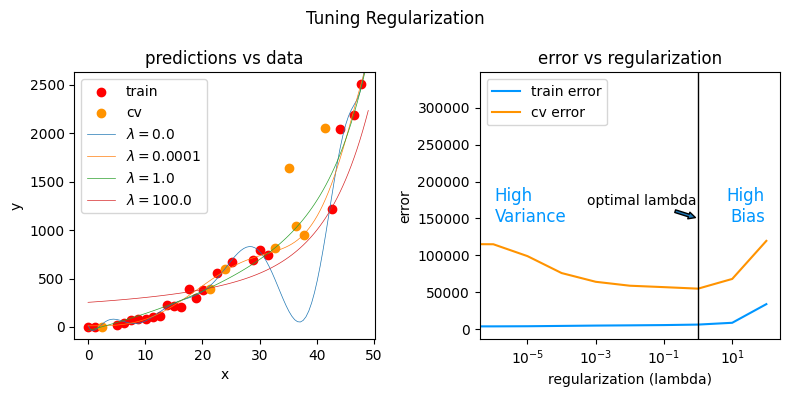

In [90]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

# Getting more data

When a model is overfitting (High Variance), collecting more data can improve performance

In [91]:
def tune_m():
    """ tune the number of examples to reduce overfitting """
    m = 50
    m_range = np.array(m*np.arange(1,16))
    num_steps = m_range.shape[0]
    degree = 16
    err_train = np.zeros(num_steps)     
    err_cv = np.zeros(num_steps)        
    y_pred = np.zeros((100,num_steps))     
    
    for i in range(num_steps):
        X, y, y_ideal, x_ideal = gen_data(m_range[i],5,0.7)
        x = np.linspace(0,int(X.max()),100)  
        X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
        X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)

        lmodel = lin_model(degree)  # no regularization
        lmodel.fit(X_train, y_train)
        yhat = lmodel.predict(X_train)
        err_train[i] = lmodel.mse(y_train, yhat)
        yhat = lmodel.predict(X_cv)
        err_cv[i] = lmodel.mse(y_cv, yhat)
        y_pred[:,i] = lmodel.predict(x)
    return(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree)

In [112]:
def plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):
    
    fig, ax = plt.subplots(1,2,figsize=(16,8))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "black", marker='x',           s=8, label="train", alpha=0.4)
    ax[0].scatter(X_cv, y_cv,       color = "teal", marker='d', s=8, label="cv",    alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,len(m_range),3):
        ax[0].plot(x, y_pred[:,i],  lw=1, label=f"$m =${m_range[i]}")
    ax[0].legend(loc='upper left')
    ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color = dlc["dlblue"])

    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(m_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning number of examples",fontsize = 12)
    ax[1].text(0.05,0.5,"High\nVariance",        fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.5,"Good \nGeneralization", fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend()
    plt.tight_layout()
    plt.show()

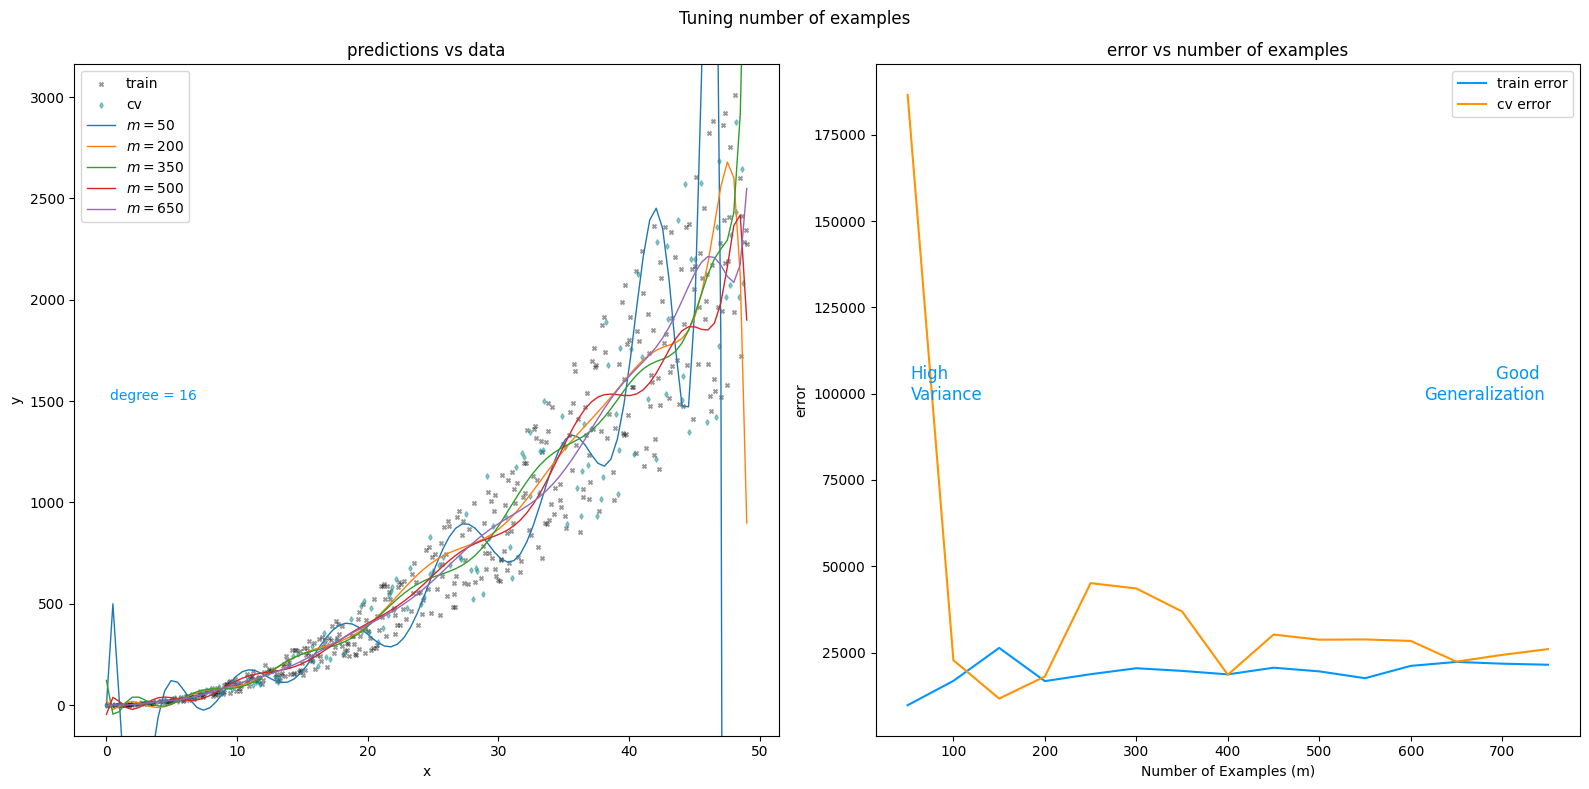

In [113]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values.

# Evaluating a Learning Algorithm (Neural Network)

In [126]:
# cm.Paired has 12 colors, alternating light and dark.
#https://matplotlib.org/stable/tutorials/colors/colormaps.html
dkcolors = plt.cm.Paired((1,3,7,9,5,11))  # pick paired colors
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors) # turn colors into a color map
ltcolors_map = mpl.colors.ListedColormap(ltcolors) # These have 6 entries - see lt_colors_map.colors

In [127]:
# Generate the data

def gen_blobs():
    classes = 6
    m = 800
    std = 0.4
    centers = np.array([[-1, 0], [1, 0], [0, 1], [0, -1],  [-2,1],[-2,-1]])
    X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=2, n_features=2)
    return (X, y, centers, classes, std)

In [128]:
def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, legend=False, size=50, m='o'):
    normy = mpl.colors.Normalize(vmin=0, vmax=classes)
    for i in range(classes):
        idx = np.where(y == i)
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                   color=map(normy(i)),
                   s=size, label=label)
    if legend: ax.legend(loc='lower right')
    ax.axis('equal')

In [129]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


In [132]:
#Plot a multi-class categorical decision boundary
# This version handles a non-vector prediction (adds a for-loop over points)
def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # create a mesh to points to plot
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    #print("points", points.shape)
    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, colors=color, linewidths=lw) 
    ax.axis('tight')

In [135]:
def recat(pt, origins):
    """ categorize a point based on distance from origin of clusters """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

In [136]:
def plt_train_eq_dist(X_train,y_train,classes, X_cv,   y_cv, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax[0], X_train,y_train,classes, map=dkcolors_map, legend=True, size=50)
    plt_mc_data(ax[0], X_cv,   y_cv,   classes, map=ltcolors_map, legend=True, m="<")
    ax[0].set_title("Training, CV Data")
    for c in css:
        circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
        ax[0].add_patch(circ)


    #make a model for plotting routines to call
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, color = dlc["dlmagenta"], lw=0.75)
    ax[1].set_title("ideal performance", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.show()

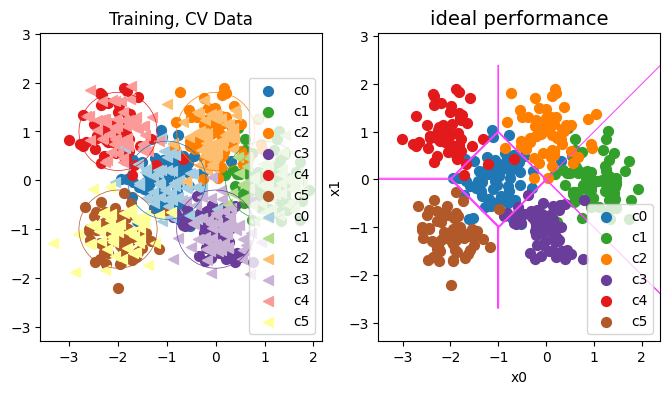

In [137]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.